In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from census_utils import *
import matplotlib.pyplot as plt

# Load synthetic data

In [164]:
DEMO_COLS = ['TOTAL', 'W', 'B', 'AI_AN', 'AS', 'H_PI', 'OTH', 'TWO_OR_MORE', 'NUM_HISP', '18_PLUS']

In [165]:
synth_df = pd.read_csv(get_synthetic_out_file())
synth_df.head()

,YEAR,STATE,STATEA,COUNTY,COUNTYA,COUSUBA,TRACTA,BLKGRPA,BLOCKA,NAME,...,AS,H_PI,OTH,TWO_OR_MORE,NUM_HISP,18_PLUS,HH_NUM,ACCURACY,AGE_ACCURACY,identifier
0,2010,Vermont,50,Addison County,1,70075,960100,1,1000,Block 1000,...,0,0,0,2,0,2,0,1,True,19601001000
1,2010,Vermont,50,Addison County,1,70075,960100,1,1000,Block 1000,...,0,0,0,0,0,1,1,1,True,19601001000
2,2010,Vermont,50,Addison County,1,70075,960100,1,1000,Block 1000,...,0,0,0,0,0,1,2,1,True,19601001000
3,2010,Vermont,50,Addison County,1,70075,960100,1,1000,Block 1000,...,0,0,0,0,0,1,3,1,True,19601001000
4,2010,Vermont,50,Addison County,1,70075,960100,1,1000,Block 1000,...,0,0,0,0,0,1,4,1,True,19601001000


In [166]:
swapped_df = pd.read_csv(get_swapped_file())
swapped_df.rename(columns={'county': 'COUNTYA', 'tract': 'TRACTA', 'X18_PLUS': '18_PLUS'}, inplace=True)
swapped_df.head()

,Unnamed: 0,W,B,AI_AN,AS,H_PI,OTH,TWO_OR_MORE,NUM_HISP,BLOCKA,...,BLOCK_18_PLUS,TOTAL,18_PLUS,U,swapped,prob,TRACTA,COUNTYA,blockid,household.id
0,1,0,0,0,0,1,0,0,0,2015,...,1,1,1,4,1,1.0,970700,3,970700-003-2022,970700-003-2015-0002
1,2,0,0,0,0,1,0,0,0,1025,...,1,1,1,4,1,1.0,10300,11,010300-011-2046,010300-011-1025-0001
2,3,0,0,0,0,1,0,0,0,4044,...,1,1,1,4,1,1.0,20200,13,020200-013-4038,020200-013-4044-0001
3,4,0,0,0,0,1,0,0,0,2019,...,1,1,1,4,1,1.0,968200,25,968200-025-2021,968200-025-2019-0001
4,5,0,0,0,0,1,0,0,0,1000,...,1,1,1,4,1,1.0,966000,27,966000-027-1018,966000-027-1000-0001


# Join the two together

In [167]:
ID_COLS = ['TRACTA', 'COUNTYA', 'BLOCKA']
def make_identifier_synth(df):
    id_lens = [6, 3, 4]
    str_cols = [col + '_str' for col in ID_COLS]
    for col, l, col_s in zip(ID_COLS, id_lens, str_cols):
        assert max(num_digits(s) for s in df[col].unique()) <= l
        df[col_s] = df[col].astype(str).str.zfill(l)
    df['id'] = df[str_cols].astype(str).agg('-'.join, axis=1)
    for col_s in str_cols:
        del df[col_s]
        
def make_identifier_swapped(df):
    df['id'] = df['household.id'].str.replace('-[0-9]+$', '')

In [168]:
make_identifier_synth(synth_df)
make_identifier_swapped(swapped_df)

/Users/manish/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  del sys.path[0]


In [199]:
def aggregate_to_block_synth(df):
    demo_cols = ['TOTAL', 'W', 'B', 'AI_AN', 'AS', 'H_PI', 'OTH', 'TWO_OR_MORE', 'NUM_HISP', '18_PLUS']
    agg_dict = {col : np.sum for col in demo_cols}
    agg_dict['AGE_ACCURACY'] = np.mean
    agg_dict['ACCURACY'] = np.mean
    df['NUM_HH'] = np.ones(len(df))
    agg_dict['NUM_HH'] = 'count'
    agg_df = df.groupby(['id', 'COUNTYA', 'TRACTA', 'BLOCKA']).agg(agg_dict).reset_index()
    return agg_df

def aggregate_to_block_swapped(df):
    demo_cols = ['TOTAL', 'W', 'B', 'AI_AN', 'AS', 'H_PI', 'OTH', 'TWO_OR_MORE', 'NUM_HISP', '18_PLUS']
    agg_dict = {col : np.sum for col in demo_cols}
    agg_dict['swapped'] = np.sum
    agg_df = df.groupby(['id']).agg(agg_dict).reset_index()
    return agg_df

In [200]:
synth_agg = aggregate_to_block_synth(synth_df)
print(len(synth_agg))
synth_agg.head()

17541


,id,COUNTYA,TRACTA,BLOCKA,TOTAL,W,B,AI_AN,AS,H_PI,OTH,TWO_OR_MORE,NUM_HISP,18_PLUS,AGE_ACCURACY,ACCURACY,NUM_HH
0,000100-007-1001,7,100,1001,66,59,7,0,0,0,0,0,4,51,1.0,2.0,28
1,000100-007-1002,7,100,1002,8,6,0,0,0,0,0,2,0,4,1.0,1.0,2
2,000100-007-1004,7,100,1004,36,36,0,0,0,0,0,0,4,26,1.0,1.0,14
3,000100-007-1005,7,100,1005,35,27,8,0,0,0,0,0,0,28,1.0,2.0,12
4,000100-007-1008,7,100,1008,720,605,23,3,61,0,5,23,21,558,1.0,2.0,290


In [201]:
swapped_agg = aggregate_to_block_swapped(swapped_df)
print(len(swapped_agg))
swapped_agg.head()

17541


,id,TOTAL,W,B,AI_AN,AS,H_PI,OTH,TWO_OR_MORE,NUM_HISP,18_PLUS,swapped
0,000100-007-1001,66,59,7,0,0,0,0,0,4,51,0
1,000100-007-1002,8,6,0,0,0,0,0,2,0,4,0
2,000100-007-1004,36,36,0,0,0,0,0,0,4,26,0
3,000100-007-1005,35,27,8,0,0,0,0,0,0,28,0
4,000100-007-1008,720,605,23,3,61,0,5,23,21,558,0


In [202]:
def merge_synth_swapped(synth_agg, swapped_agg):
    df = synth_agg.merge(swapped_agg,
                        how='inner',
                        on='id',
                        suffixes=('_sy', '_sw'),
                        validate='one_to_one')
    return df

In [339]:
df = merge_synth_swapped(synth_agg, swapped_agg)
df.head()

,id,COUNTYA,TRACTA,BLOCKA,TOTAL_sy,W_sy,B_sy,AI_AN_sy,AS_sy,H_PI_sy,...,W_sw,B_sw,AI_AN_sw,AS_sw,H_PI_sw,OTH_sw,TWO_OR_MORE_sw,NUM_HISP_sw,18_PLUS_sw,swapped
0,000100-007-1001,7,100,1001,66,59,7,0,0,0,...,59,7,0,0,0,0,0,4,51,0
1,000100-007-1002,7,100,1002,8,6,0,0,0,0,...,6,0,0,0,0,0,2,0,4,0
2,000100-007-1004,7,100,1004,36,36,0,0,0,0,...,36,0,0,0,0,0,0,4,26,0
3,000100-007-1005,7,100,1005,35,27,8,0,0,0,...,27,8,0,0,0,0,0,0,28,0
4,000100-007-1008,7,100,1008,720,605,23,3,61,0,...,605,23,3,61,0,5,23,21,558,0


# Load map data

In [340]:
def load_shape_data():
    block_map = gpd.read_file(get_shape_file())
    block_grp_map = gpd.read_file(get_grp_shape_file())
    return block_map.to_crs("EPSG:3395"), block_grp_map.to_crs("EPSG:3395")

In [341]:
block_map, block_grp_map = load_shape_data()

In [342]:
block_map.head()

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,GISJOIN,Shape_Area,Shape_len,geometry
0,50,001,961000,1066,500019610001066,Block 1066,G5040,None,None,S,66368.0,0.0,+43.9053063,-073.0819173,G50000109610001066,66368.017716,1856.491082,"POLYGON ((-8135282.154 5421251.873, -8135273.8..."
1,50,001,961000,1026,500019610001026,Block 1026,G5040,None,None,S,21966.0,0.0,+43.9541479,-073.1343633,G50000109610001026,21965.560825,625.344558,"POLYGON ((-8141266.245 5428517.638, -8141277.2..."
2,50,001,961000,1083,500019610001083,Block 1083,G5040,None,None,S,17084.0,0.0,+43.9048183,-073.0635069,G50000109610001083,17083.933569,529.044846,"POLYGON ((-8133321.150 5421000.446, -8133325.8..."
3,50,001,961000,1007,500019610001007,Block 1007,G5040,None,None,S,273.0,0.0,+43.9238605,-073.0844993,G50000109610001007,273.126674,137.317265,"POLYGON ((-8135715.521 5423949.499, -8135719.1..."
4,50,001,960900,3055,500019609003055,Block 3055,G5040,None,None,S,0.0,4686.0,+43.8725811,-073.2686426,G50000109609003055,4685.346797,318.855936,"POLYGON ((-8156231.481 5416041.827, -8156249.8..."


In [343]:
def make_GISJOIN(df):
    block_df = pd.read_csv(get_block_file())
    block_df = block_df[['GISJOIN', 'COUNTYA', 'TRACTA', 'BLOCKA', 'SLDUA', 'SLDLA']]
    return df.merge(block_df,
             how='inner',
             on=['COUNTYA', 'TRACTA', 'BLOCKA'],
             validate='one_to_one')

In [344]:
df = make_GISJOIN(df)

In [345]:
df.head()

,id,COUNTYA,TRACTA,BLOCKA,TOTAL_sy,W_sy,B_sy,AI_AN_sy,AS_sy,H_PI_sy,...,AS_sw,H_PI_sw,OTH_sw,TWO_OR_MORE_sw,NUM_HISP_sw,18_PLUS_sw,swapped,GISJOIN,SLDUA,SLDLA
0,000100-007-1001,7,100,1001,66,59,7,0,0,0,...,0,0,0,0,4,51,0,G50000700001001001,CHI,C31
1,000100-007-1002,7,100,1002,8,6,0,0,0,0,...,0,0,0,2,0,4,0,G50000700001001002,CHI,C31
2,000100-007-1004,7,100,1004,36,36,0,0,0,0,...,0,0,0,0,4,26,0,G50000700001001004,CHI,C31
3,000100-007-1005,7,100,1005,35,27,8,0,0,0,...,0,0,0,0,0,28,0,G50000700001001005,CHI,C31
4,000100-007-1008,7,100,1008,720,605,23,3,61,0,...,61,0,5,23,21,558,0,G50000700001001008,CHI,C31


In [346]:
def add_geo(df, map_df):
    return map_df.merge(df,
                        how='left',
                        on='GISJOIN',
                        validate='one_to_one')

In [347]:
df = add_geo(df, block_map)
print(len(df))
df.head()

32580


,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,FUNCSTAT10,...,AI_AN_sw,AS_sw,H_PI_sw,OTH_sw,TWO_OR_MORE_sw,NUM_HISP_sw,18_PLUS_sw,swapped,SLDUA,SLDLA
0,50,001,961000,1066,500019610001066,Block 1066,G5040,None,None,S,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,ADD,A-2
1,50,001,961000,1026,500019610001026,Block 1026,G5040,None,None,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,50,001,961000,1083,500019610001083,Block 1083,G5040,None,None,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,50,001,961000,1007,500019610001007,Block 1007,G5040,None,None,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50,001,960900,3055,500019609003055,Block 3055,G5040,None,None,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Analysis

In [348]:
print('Total number of swaps:', df['swapped'].sum())
print('Swap rate:', df['swapped'].sum() / df['NUM_HH'].sum())

Total number of swaps: 2444.0
Swap rate: 0.009307320565598711


In [349]:
def plot_column(df, col, title=''):
    fig, ax = plt.subplots(figsize=(12, 12))
    df.plot(ax=ax,
            column=col,
            cmap='Reds',
            legend=True,
            missing_kwds={'color': 'grey'})
    block_grp_map.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=.2)
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()

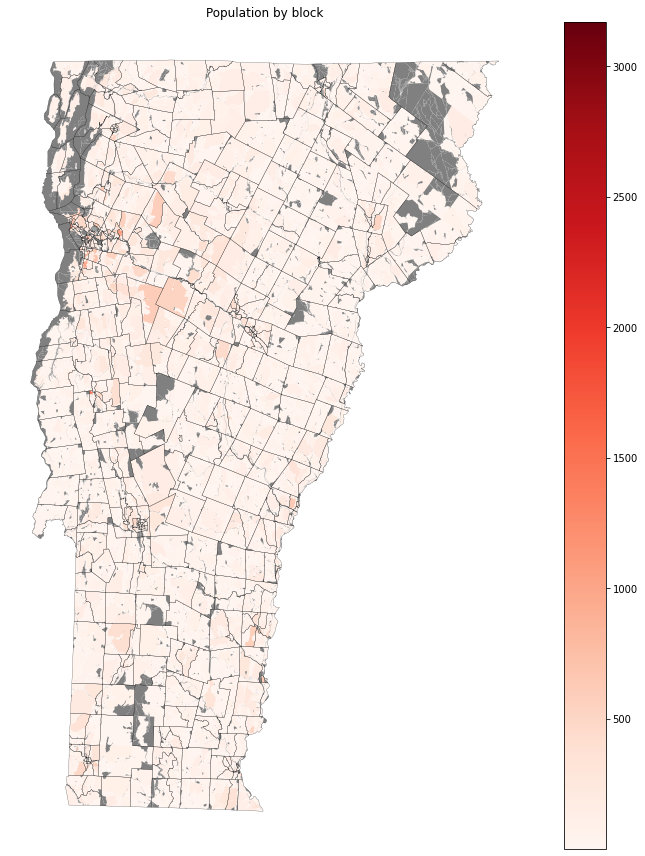

In [350]:
plot_column(df, 'TOTAL_sy', 'Population by block')

## Race/ethnicity changes

In [351]:
def r_eth_changes(df):
    diffs = None
    r_eth_cols = ['W', 'B', 'AI_AN', 'AS', 'H_PI', 'OTH', 'TWO_OR_MORE', 'NUM_HISP']
    for c in r_eth_cols:
        if diffs is None:
            diffs = np.abs(df[c + '_sw'] - df[c + '_sy'])
        else:
            diffs += np.abs(df[c + '_sw'] - df[c + '_sy'])
    print('Total number of race/eth changes at the block level:', diffs.sum())
    c_name = 'r_eth_diff'
    df[c_name] = diffs
    plot_column(df, c_name, 'Change in racial counts')
    del df[c_name]

Total number of race/eth changes at the block level: 1356.0


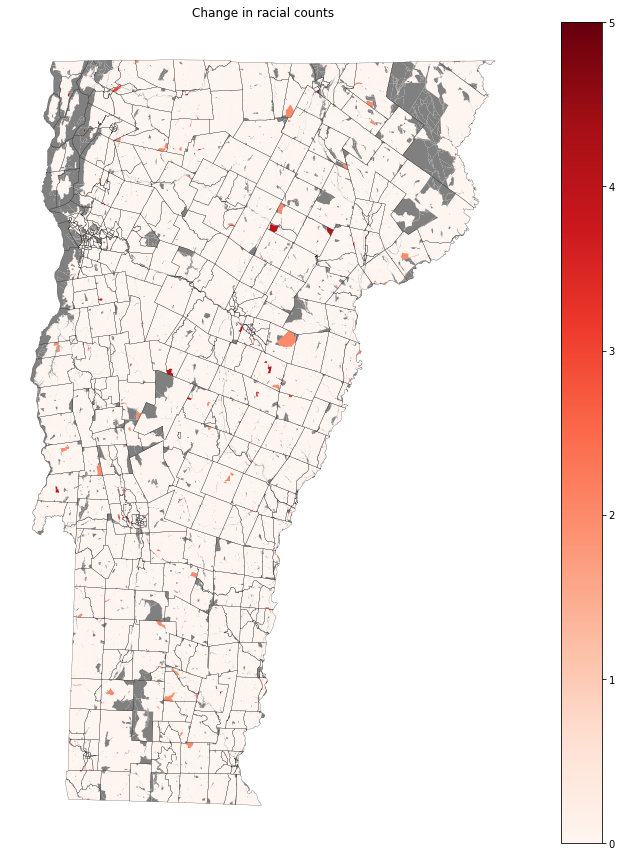

In [354]:
r_eth_changes(df)

In [355]:
def pct_white_changes(df):
    before_pct_white = df['W_sy'] / df['TOTAL_sy']
    after_pct_white = df['W_sw'] / df['TOTAL_sw']
    c_name = 'pct_white_change'
    df[c_name] = np.abs(after_pct_white - before_pct_white)
    plot_column(df, c_name, 'Change in pct white')
    del df[c_name]

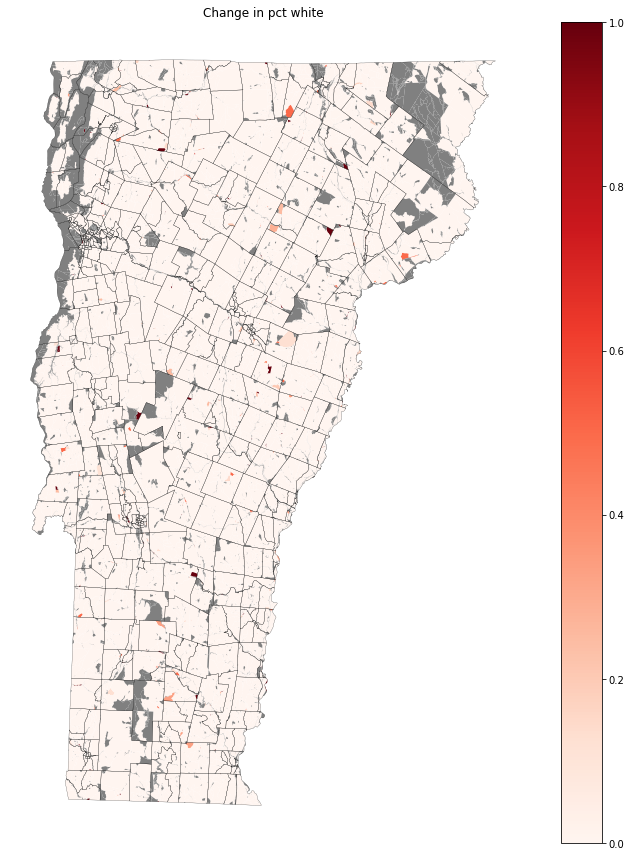

In [356]:
pct_white_changes(df)

## Voting areas
Here, we look at the change in percent white at the voting district level (state upper and lower assemblies).

In [358]:
def get_aggregated_df(df, col):
    demo_cols = ['TOTAL', 'W', 'B', 'AI_AN', 'AS', 'H_PI', 'OTH', 'TWO_OR_MORE', 'NUM_HISP', '18_PLUS']
    agg_dict = {col + '_sw' : np.sum for col in demo_cols}
    agg_dict.update({col + '_sy' : np.sum for col in demo_cols})
    return df.groupby(col).agg(agg_dict)

In [359]:
def pct_white_changes_stats(df, col):
    grouped = get_aggregated_df(df, col)
    print('There are', len(grouped), col + "'s")
    before_pct_white = grouped['W_sy'] / grouped['TOTAL_sy']
    after_pct_white = grouped['W_sw'] / grouped['TOTAL_sw']
    diff = after_pct_white - before_pct_white
    print('Largest absolute fractional change: {:.3g}'.format(np.max(np.abs(diff))))
    plt.figure()
    diff.plot.hist()
    plt.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    plt.title('Change in % white at ' + col)

There are 108 SLDLA's
Largest absolute fractional change: 0.000689
There are 13 SLDUA's
Largest absolute fractional change: 9.98e-05
There are 14 COUNTYA's
Largest absolute fractional change: 0.000109
There are 183 TRACTA's
Largest absolute fractional change: 0.00147


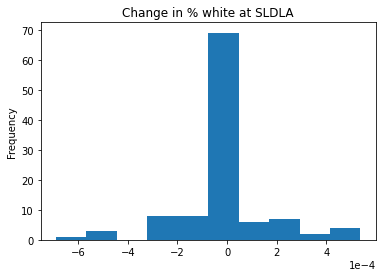

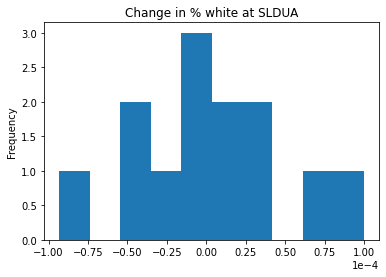

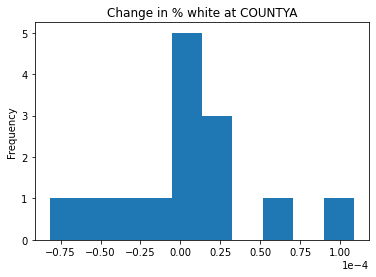

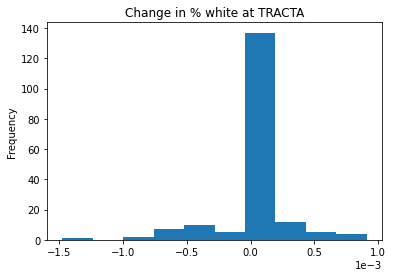

In [365]:
pct_white_changes_stats(df, 'SLDLA')
pct_white_changes_stats(df, 'SLDUA')
pct_white_changes_stats(df, 'COUNTYA')
pct_white_changes_stats(df, 'TRACTA')

## Majority minority district analysis
There are no MMDs in Vermont, so we wouldn't expect an effect here. But this code will be useful in the future.

In [366]:
def mmd_analysis(df, col):
    df = get_aggregated_df(df, col)
    before_mmd = df['W_sy'] / df['TOTAL_sy'] < .5
    after_mmd = df['W_sw'] / df['TOTAL_sw'] < .5
    change = before_mmd != after_mmd
    num_changes = change.sum()
    plt.figure()
    (df['W_sw'] / df['TOTAL_sw']).plot.hist(label=col)
    plt.title('Fraction white (swapped) ' + col)
    print('Number of MMD changes at', col, 'level:', num_changes, 'out of', len(df))

Number of MMD changes at SLDLA level: 0 out of 108
Number of MMD changes at SLDUA level: 0 out of 13
Number of MMD changes at COUNTYA level: 0 out of 14
Number of MMD changes at TRACTA level: 0 out of 183


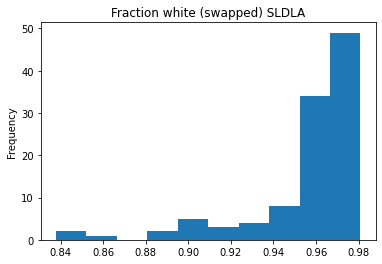

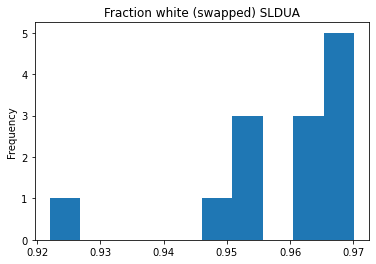

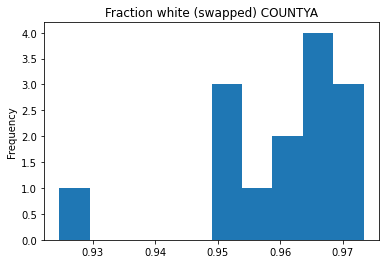

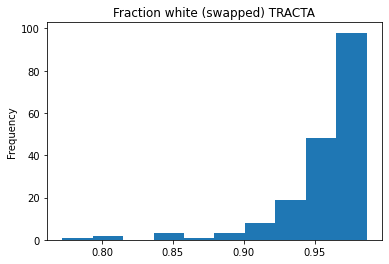

In [367]:
for level in ['SLDLA', 'SLDUA', 'COUNTYA', 'TRACTA']:
    mmd_analysis(df, level)